# Extending Logistic Regression: 2009 American Community Survey

### Nick Chao

### Preparation and Overview (20 points total)

[10 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results.

[5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

[5 points] Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset? 


### Modeling (50 points total)

[20 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. 
Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

[15 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

[15 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

### Deployment (10 points total)
Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

### Exceptional Work (10 points total)
You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. 
One idea (required for 7000 level students): Implement an optimization technique for logistic regression using mean square error as your objective function (instead of binary entropy). Your solution should be able to solve the binary logistic regression problem in one gradient update step. 


## Data Overview

In this lab, we investigate possible relationships between an individual's income and attributes about them. The data used in this lab is provided by the 2009 American Community Survey 1-Year PUMS Population File which can be found here. https://catalog.data.gov/dataset/2009-american-community-survey-1-year-pums-population-file. This dataset contains more than 3 million entries and nearly 300 attributes. To make sense of some of these attributes, there is a dictionary lookup that provides more information about the columns. You can find this reference here. https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict09.pdf.

To be more specific, we want to see if we can predict a person's current income based on factors about themselves that they might give away when applying for a new job. For example, their age, sex, education level, and more are just a few peices of information that companies may ask for when applying for a new job. 

This information could be incrediably useful for a company that is hiring new personal. If they know the current income of someone who has applied for a job at their company, then they can offer the lowest starting salary they believe the new canadate will accept. (i.e. slightly above what they currently make). 


In [124]:
#importing dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score
from scipy.optimize import fmin_bfgs
from scipy.special import expit

import warnings
warnings.filterwarnings('ignore')

In [2]:
%time dataA = pd.read_csv('../data/ss09pusa.csv')
%time dataB = pd.read_csv('../data/ss09pusb.csv')
merged = pd.concat([dataA,dataB])

Wall time: 30.7 s
Wall time: 27 s


In [3]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3030728 entries, 0 to 1466654
Columns: 279 entries, RT to pwgtp80
dtypes: float64(86), int64(190), object(3)
memory usage: 6.3+ GB


In [4]:
print('The 2009 American Community Survey has a lot of data, look at all these columns! \n\n'+str(list(merged.columns.values)))
print('\nNo wonder they provide a reference dictionary to figure out what all these acronyms mean')

The 2009 American Community Survey has a lot of data, look at all these columns! 

['RT', 'SERIALNO', 'SPORDER', 'PUMA', 'ST', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'INTP', 'JWMNP', 'JWRIP', 'JWTR', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPC', 'MLPD', 'MLPE', 'MLPF', 'MLPG', 'MLPH', 'MLPI', 'MLPJ', 'MLPK', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'OIP', 'PAP', 'REL', 'RETP', 'SCH', 'SCHG', 'SCHL', 'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKW', 'WRK', 'YOEP', 'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR', 'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR

### Data Preparation

Obviously there is way more data here than we need so lets start by reducing the number of columns to only what we consider useful for our classification. The following attributes will remain as they are peices of information that new hires might give away when applying for a job.

Citizenship, age, class of work, English fluentcy, martial status, military status, sex, education background, disability status, race, geographical location. We will also keep the individual's income as it is the attribute that we are attempting to predict. 

In [5]:
cols_to_save = ['CIT','AGEP','COW','ENG','MAR','MIL','SCHL','SEX','DIS','PINCP','POWSP','RAC1P','FOD1P']
new_data = merged.filter(items=cols_to_save)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3030728 entries, 0 to 1466654
Data columns (total 13 columns):
CIT      int64
AGEP     int64
COW      float64
ENG      float64
MAR      int64
MIL      float64
SCHL     float64
SEX      int64
DIS      int64
PINCP    float64
POWSP    float64
RAC1P    int64
FOD1P    float64
dtypes: float64(7), int64(6)
memory usage: 323.7 MB


In [6]:
new_data

,CIT,AGEP,COW,ENG,MAR,MIL,SCHL,SEX,DIS,PINCP,POWSP,RAC1P,FOD1P
0,1,51,NaN,NaN,4,3.0,16.0,1,1,3800.0,NaN,1,NaN
1,1,64,1.0,NaN,1,5.0,19.0,2,1,36800.0,1.0,1,NaN
2,1,68,1.0,NaN,1,3.0,14.0,1,1,54600.0,1.0,1,NaN
3,1,61,1.0,NaN,3,5.0,16.0,2,2,6000.0,1.0,2,NaN
4,1,38,1.0,NaN,5,5.0,16.0,1,2,14000.0,1.0,2,NaN
5,1,65,6.0,NaN,1,5.0,16.0,2,1,13000.0,NaN,1,NaN
6,1,74,1.0,NaN,1,3.0,16.0,1,1,45200.0,1.0,1,NaN
7,1,23,1.0,NaN,5,5.0,12.0,2,1,820.0,NaN,1,NaN
8,1,42,1.0,NaN,1,5.0,19.0,2,2,25200.0,1.0,1,NaN
9,1,42,1.0,NaN,1,5.0,13.0,1,2,56000.0,1.0,1,NaN


We began with over 3 million records and 279 differnt attributes provided in the survey. Of the nearly 300 attributes that were provided in the dataset, we reduced it down to the thirteen shown above. The table below shows the desired attributes and examples of what we would want the data to look like. 

|Attribute|Description|Type|Example|
|:---:|:---:|:---:|:---:|
| CIT | Citizenship Status | Int | 1. Citizen, 0. Non-citizen |
| AGEP | Age | Int | 23
| COW | Class of Worker | Float | 3. Local Government, 4. State Government |
| ENG | Ability to speak English  | Int | 1. Speaks English, 0. Doesn't Speak English |
| MAR | Marital Status | Int | 1. Married, 2. Widowed |
| MIL | Military Service | Int | 1. Yes, 0. No |
| SCHL | Educational Attainment  | Float | 21 Bachelor's Degree, 22 Master's Degree |
| SEX | Sex      | Int | True. Male |
| DIS | Disability | Int | True. Disabled |
| PINCP | Total Person's Income | Float
| POWSP | Place of work | Float | 048 Texas, 049 Utah |
| RAC1P | Detailed Race Code | Int | 1 White, 6 Asian |
| FOD1P | Field of Degree | Float | 2407 Computer Engineering, 2408 Electrical Engineering |

### Data Cleaning

The next step is data cleaning and modifying the data into more useful data types. Lets start by modifying some of these data types into more useful and proper variables.

In [7]:
# Change citizenship to Int.
# 1-4 is a citizen (true) and 5 is not a citizen (false)

new_data.CIT.replace(to_replace = range(5),
                    value=[1,1,1,1,0],
                    inplace=True)
new_data['CIT'] = new_data['CIT'].astype('int')

In [8]:
# Change Ability to Speak English to boolean
# b is N/A but it would be a good assumption to assume they speak English
new_data['ENG']=new_data['ENG'].fillna(1)
# 1-2 speaks English well or very well, 3-4 speaks English not well or not at all.
new_data.ENG.replace(to_replace = range(4),
                    value=[1,1,0,0],
                    inplace=True)
new_data['ENG'] = new_data['ENG'].astype('int')# Change Military Status to Boolean

In [9]:
# b is N/A because less than 17 years old so lets just change this to 0
new_data['MIL']=new_data['MIL'].fillna(0)
# 1-3 Yes, 4-5 No
new_data.MIL.replace(to_replace = range(5),
                    value=[1,1,1,0,0],
                    inplace=True)
new_data['MIL'] = new_data['MIL'].astype('int')

In [10]:
# # Change Sex to Int
# # 1 is male, 2 is female. Changing 2 to 0 for boolean conversion
# new_data.SEX.replace(to_replace = range(2),
#                     value=[1,0],
#                     inplace=True)
# new_data['SEX'] = new_data['SEX'].astype('Int')

In [11]:
# # Change DIS to Int
# # 1 is disabled, 2 is no disability. Changing 2 to 0 for boolean conversion
# new_data.DIS.replace(to_replace = range(2),
#                     value=[1,0],
#                     inplace=True)
# new_data['DIS'] = new_data['DIS'].astype('Int')

In [12]:
# Change Educational Atttainment to INT
# bb is N/A for less than 3 years old.
new_data['SCHL']=new_data['SCHL'].fillna(0)
# For this classification lets simplify some of these education levels.
# 0 between No schooling and Grade 8
# 1 between Grade 9 and Grade 12 no diploma
# 2 for High School degree or GED
# 3 Some college to Associate's degree
# 4 Bachelor's Degree
# 5 Master's Degree
# 6 Professional degree or Doctorate
new_data.SCHL.replace(to_replace = range(25),
                    value=[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,3,3,3,4,5,6,6],
                    inplace=True)
new_data['SCHL'] = new_data['SCHL'].astype('int')

Next, lets remove all entries with people under the age of 18 because our goal is to focus on personal income of working class individuals.

In [13]:
# delete younger than 18
new_data = new_data[new_data.AGEP >= 18]
#new_data

Now lets work on the Nulls...

In [14]:
# find null columns
print('Columns that contain nulls: '+str(new_data.columns[new_data.isnull().any()].tolist()))

Columns that contain nulls: ['COW', 'POWSP', 'FOD1P']


For Field of Study, we can replace all the Nulls with 0s since they only refer to those with at least a college degree
Let's remove any Class of Worker and Place of Work rows with Nulls since those entres are for idividuals who have not worked

In [15]:
# Field of Study  -> 0
# Class of Worker -> Remove if Null
# Place of Work   -> Remove if Null

new_data['FOD1P'].fillna(0, inplace=True)
new_data = new_data[pd.notnull(new_data['COW'])]
new_data = new_data[pd.notnull(new_data['POWSP'])]

# Convert the Floats to Ints
# COW, POWSP, FOD1P, PINCP

new_data['COW'] = new_data['COW'].astype('int')
new_data['POWSP'] = new_data['POWSP'].astype('int')
new_data['FOD1P'] = new_data['FOD1P'].astype('int')
new_data['PINCP'] = new_data['PINCP'].astype('int')

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
# Double check for null columns
print('Columns that contain nulls: '+str(new_data.columns[new_data.isnull().any()].tolist()))

Columns that contain nulls: []


We will start by splitting the personal income data into 2 different classes to test Binary Logistic Regression. Later, we will split the personal income into 5 different classes. This will help verify our income predictions while also being specific enough to work with our business goal.

In [17]:
# future_data = new_data.copy(deep=False) # saving a copy for later

# new_data['PINCP'] = pd.qcut(new_data.PINCP, 2, labels=[0,1])
# new_data['PINCP'].unique()

#qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
#cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)

new_data['PINCP'] = pd.qcut(new_data.PINCP, 5, labels=[0,1,2,3,4])
new_data['PINCP'].unique()

[2, 3, 0, 1, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [18]:
new_data['PINCP'] = new_data['PINCP'].astype(np.int)

In [19]:
# Lets see how the income classes have split...
print('Number of people in each class:')
for value in new_data.PINCP.unique(): 
    print(str(value)+': ' +str(len(new_data[new_data['PINCP'] == value])))

Number of people in each class:
2: 233964
3: 268048
0: 267705
1: 302608
4: 265954


In [20]:
# Finally, let's rename some of these columns so they make more sense.
new_data.rename(columns={'CIT': 'Citizenship','AGEP': 'Age','COW': 'Class of Work','ENG': 'Speaks English','MAR': 'Martial Status','MIL': 'Military Status','SCHL': 'Education Level','SEX': 'Male','DIS': 'Disabled?','PINCP': 'Income','POWSP': 'Place of Work','RAC1P': 'Race','FOD1P': 'Field of Study'}, inplace=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338279 entries, 1 to 1466654
Data columns (total 13 columns):
Citizenship        1338279 non-null int32
Age                1338279 non-null int64
Class of Work      1338279 non-null int32
Speaks English     1338279 non-null int32
Martial Status     1338279 non-null int64
Military Status    1338279 non-null int32
Education Level    1338279 non-null int32
Male               1338279 non-null int64
Disabled?          1338279 non-null int64
Income             1338279 non-null int32
Place of Work      1338279 non-null int32
Race               1338279 non-null int64
Field of Study     1338279 non-null int32
dtypes: int32(8), int64(5)
memory usage: 102.1 MB


### Training and Testing

As we can see above, there is still a significant amount of data for testing and training purposes (Over 1.3 million entries). The next step is to determine how much of the data should be used immediately for training purposes and how much should be saved until the end for testing purposes. 

An 80/20 split seems to be a good number for this situation. As long as the split is randomized and there would be over a million entries just for training, and around a quarter of a million entries for testing. That seems like plenty of data to create a accurate model as well as test the model for it's accuracy. Furthermore, since we will be spliting the income into five classes, the 80/20 split seems appropriate.

In [21]:
# Lets start by making a copy of the cleaned data we are using.
new_df = new_data.copy()
if 'Income' in new_data:
    y = new_df['Income'].values    # Since Income is our target class, lets make a copy of it
    del new_df['Income']           # Now we need to remove the target class
    X = new_df.values              # The remaining data will be used to train

# Scikit Learns provides a way to split our data into training and testing subsets.
cv_object = ShuffleSplit(train_size=.8, test_size=0.2, n_splits=1)
                         
print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=0.8)


## Modeling

The goal is to create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. 
Let's start by using the template from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb

We will add and modify functions as required.

In [52]:
# from https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb
# and from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb
# and from https://github.com/carterkoehler/extending-logistic-regression/blob/master/notebooks/logistic-regression-dengue-fever.ipynb

from scipy.special import expit

class BinaryLogisticRegressionBase:
    
    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=100,
                C=0.1,
                reg='l1',
                tol=1e-3,
                solver='newton'
               ):
        self.alpha = np.float64(alpha)
        self.max_it = np.int(iterations)
        self.tol = np.float64(tol)
        self.C = np.float64(C)
        self.threshold = np.float64(threshold)
        
        # Check to see if valid parameters
        if solver not in ['steepest', 'stochastic', 'newton']:
            raise ValueError('That is not a valid value for solver.')
        else:
            self.solver = solver
        
        if reg not in ['l1', 'l2', 'l1_and_l2']:
            raise ValueError('That is not a valid value for reg.')
        else:
            self.reg = reg
        
    @staticmethod
    def _sigmoid(theta):
        return 1/(1 + np.exp(-theta))
    
    @staticmethod
    def _add_bias(X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _regularize(self):
        if self.reg == 'l1':
            return np.sum(self.w_/abs(self.w_))
            
        elif self.reg == 'l2':
            return 2 * np.sum(self.w_)
            
        elif self.reg == 'l1_and_l2':
            return np.sum(self.w_/abs(self.w_)) + 2 * np.sum(self.w_)
        else:
            raise ValueError('bad value')        

    def predict_proba(self, X, add_bias=True):
        return (expit(self._add_bias(X) @ self.w_) if add_bias else expit(X @ self.w_))
        
    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(np.int)

In [53]:
# from https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb
# and from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb
# and from https://github.com/carterkoehler/extending-logistic-regression/blob/master/notebooks/logistic-regression-dengue-fever.ipynb

class BinaryLogisticRegression(BinaryLogisticRegressionBase):

    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=100,
                C=0.1,
                reg='l1',
                tol=1e-3,
                solver='newton'
               ):
        super().__init__(
            alpha=alpha,
            threshold=threshold,
            iterations=iterations,
            C=C,
            reg=reg,
            tol=tol,
            solver=solver
        )
        
    @staticmethod
    def bfgs_grad(w,D,y,C):
        return -(np.mean(D * (y - expit(D @ w))[:,np.newaxis], axis=0) - 2 * w * C)
    
    @staticmethod
    def bfgs_obj(w,D,y,C):
        return -np.sum(np.log(expit(D @ w)[y==1])) - np.sum(1 - np.log(expit(D @ w)[y==0])) + C * np.sum(w**2)

    def _gradient(self, X, y):
        if self.solver == 'steepest':
            ydiff = y-self.predict_proba(X, add_bias=False).ravel()
            #g = self.predict_proba(X, add_bias=False)
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
            #return np.sum(X * ((-2 * (y-g) * (-g * (1-g)) )[:,np.newaxis]), axis=0)
            return gradient.reshape(self.w_.shape)
        elif self.solver == 'stochastic':
            idx = np.random.choice(X.shape[0])
            return (y[idx] - self.predict_proba(X[idx,:], add_bias=False)) * X[idx,:] - self.C * self._regularize()
        else:
            raise ValueError('The value for the \'solver\' attribute is something it should not be.')
    
    def fit(self, X, y):
        Xfit = self._add_bias(X)
        self.w_ = np.random.rand(Xfit.shape[1], 1).ravel()

        if self.solver == 'newton':
            self.w_ = fmin_bfgs(BinaryLogisticRegression.bfgs_obj,
                                np.random.rand(Xfit.shape[1], 1),
                                fprime=BinaryLogisticRegression.bfgs_grad,
                                args=(Xfit, y, self.C),
                                gtol=self.tol,
                                maxiter=self.max_it,
                                disp=False)
        else:
            for i in range(self.max_it):
                grad = self._gradient(Xfit, y)
                self.w_ += self.alpha * grad.ravel()
                if np.mean(abs(grad)) <= self.tol:
                    break

In [54]:
# from https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb
# and from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb
# and from https://github.com/carterkoehler/extending-logistic-regression/blob/master/notebooks/logistic-regression-dengue-fever.ipynb

class MultiClassLogisticRegression:
    
    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=500,
                C=0.1,
                reg='l2',
                tol=1e-3,
                solver='stochastic',
                multiclass='ovr'
               ):
        self.alpha = np.float64(alpha)
        self.max_it = np.int(iterations)
        self.tol = np.float64(tol)
        self.C = np.float64(C)
        self.threshold = np.float64(threshold)
        self.reg = reg
        self.solver = solver
        self.multiclass = multiclass
        
    def fit(self, X, y):
        self.models_ = []
        if self.multiclass == 'ovr':
            for i in np.unique(y):
                blr = BinaryLogisticRegression(alpha=self.alpha,
                                               threshold=self.threshold,
                                               solver=self.solver,
                                               iterations=self.max_it,
                                               C=self.C,
                                               reg=self.reg,
                                               tol=self.tol
                                              )
                blr.fit(X, y==i)
                self.models_.append(blr)
        else:
            raise ValueError('bad value.')
        
    def predict_proba(self, X):
        probs = []
        for pred in self.models_:
            probs.append(pred.predict_proba(X).T)
            
        return np.vstack(probs)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0).T

Lets start by using scikit-learn's logistic refression classifier as a base of reference

In [55]:
# Modified from https://github.com/egabrielsen/MachineLearning/blob/master/Lab04/Lab04-Final.ipynb

lr_clf = LogisticRegression()

# We will use the cv_object we created earilier and iterate through the different training and testing sets.

for train_index, test_index in cv_object.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]   
    X_test = X[test_index]
    y_test = y[test_index]
    
    # train the reusable logisitc regression model on the training data
    %time lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    for i in range(0,len(conf)):
        print("Accuracy for income bracket", i, ":",conf[i][i]/sum(conf[i]))
    print("Overall accuracy:", acc )
    print("Confusion matrix\n",conf)

Wall time: 1min 16s
Accuracy for income bracket 0 : 0.5536707296523058
Accuracy for income bracket 1 : 0.4375185563949461
Accuracy for income bracket 2 : 0.00019276901987662782
Accuracy for income bracket 3 : 0.17432249196649144
Accuracy for income bracket 4 : 0.6860968811209884
Overall accuracy: 0.38078354305526496
Confusion matrix
 [[29571 15788     4  2781  5265]
 [20205 26525    19  5423  8454]
 [ 9871 18658     9  7043 11107]
 [ 6911 16037     5  9385 21499]
 [ 2876  7470     4  6317 36429]]


Our base accuracy is around 38%. Note that this accuracy will vary everytime you run the above code.
Let's now test our Binary classifiers...

In [56]:
# Modified from https://github.com/egabrielsen/MachineLearning/blob/master/Lab04/Lab04-Final.ipynb

%%time

# Stochastic Test
for train_index, test_index in cv_object.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]   
    X_test = X[test_index]
    y_test = y[test_index]
    
    sgd = MultiClassLogisticRegression(alpha=0.2, iterations=800, solver='stochastic', reg='l2', C=0.1)
    sgd.fit(X_train, y_train)
    
    yhat = sgd.predict(X_train)
    print('Accuracy of: ',accuracy_score(y_train,yhat))

Accuracy of:  0.2003431646807513
Wall time: 1.1 s


In [57]:
%%time

# Newton Test
for train_index, test_index in cv_object.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]   
    X_test = X[test_index]
    y_test = y[test_index]
    
    nwt = MultiClassLogisticRegression(alpha=0.01, iterations=2, solver='newton', reg='l2', C=0.1)
    nwt.fit(X_train, y_train)
    
    yhat = nwt.predict(X_train)
    print('Accuracy of: ',accuracy_score(y_train,yhat))

C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


Accuracy of:  0.3184958664254364
Wall time: 8.67 s


In [58]:
%%time

# Steepest Test
for train_index, test_index in cv_object.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]   
    X_test = X[test_index]
    y_test = y[test_index]
    
    steep = MultiClassLogisticRegression(alpha=0.01, iterations=2, solver='steepest', reg='l2', C=0.1)
    steep.fit(X_train, y_train)
    
    yhat = steep.predict(X_train)
    print('Accuracy of: ',accuracy_score(y_train,yhat))

Accuracy of:  0.16481431839218846
Wall time: 2.04 s


### Optimization

Now that we know that all the above methods work, let's figure out how to optimize the classifiers by changing the regularization term "C".

In [69]:
# Modified from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb

%%time
import copy
#We tested C's above 1 and they all offer same results. 
c_list = [0.001,0.01,0.1,1,10] #0.001,0.01,0.1,1,10]
optimization_list = ['newton','stochastic','steepest']
regularization_list = ['l1','l2','l1_and_l2']
#eta = 0.1

iterations = {
    'newton':3,
    'stochastic':1000,
    'steepest':1000
}
tests = {}
results = {}

tests = dict.fromkeys(regularization_list,dict.fromkeys(optimization_list,[]))
results = []

for optimization in optimization_list:
    for regularization in regularization_list:
        for c in c_list:
            test = None
            test = MultiClassLogisticRegression(iterations=iterations[optimization],C=float(c),solver=optimization,reg=(regularization))
            test.fit(X_train,y_train)
            yhat = test.predict(X_test)
            score = accuracy_score(y_test,yhat)
            print("Norm:",regularization,'| Method:',str(optimization),'| C:',str(c),'| Accuracy of: ',score)
            results.append(score)  
        print()
    print()
    print()

Norm: l1 | Method: newton | C: 0.001 | Accuracy of:  0.14243282422213588
Norm: l1 | Method: newton | C: 0.01 | Accuracy of:  0.2313641390441462
Norm: l1 | Method: newton | C: 0.1 | Accuracy of:  0.1679170278267627
Norm: l1 | Method: newton | C: 1 | Accuracy of:  0.2431740741847745
Norm: l1 | Method: newton | C: 10 | Accuracy of:  0.1646740592402188

Norm: l2 | Method: newton | C: 0.001 | Accuracy of:  0.29645141524942464
Norm: l2 | Method: newton | C: 0.01 | Accuracy of:  0.26602056370864097
Norm: l2 | Method: newton | C: 0.1 | Accuracy of:  0.23850016439011268
Norm: l2 | Method: newton | C: 1 | Accuracy of:  0.2721627761006665
Norm: l2 | Method: newton | C: 10 | Accuracy of:  0.3024441820844666

Norm: l1_and_l2 | Method: newton | C: 0.001 | Accuracy of:  0.2116447978001614
Norm: l1_and_l2 | Method: newton | C: 0.01 | Accuracy of:  0.24904728457422962
Norm: l1_and_l2 | Method: newton | C: 0.1 | Accuracy of:  0.27705338195295454
Norm: l1_and_l2 | Method: newton | C: 1 | Accuracy of:  0.

Now that we have some data to look at, let's visualize and compare.

In [108]:
# First we need to divide the results into the different classifiers

# Newton
newtonResults1 = results[0:5]
newtonResults2 = results[5:10]
newtonResults3 = results[10:15]
#print(newtonResults1)

#print(newtonResults1)

NewtonMatrix = np.array([newtonResults1, newtonResults2, newtonResults3]).transpose()


# Stochastic
stochResults1 = results[15:20]
stochResults2 = results[20:25]
stochResults3 = results[25:30]
StochMatrix = np.array([stochResults1, stochResults2, stochResults3]).transpose()

# Steepest
steepResults1 = results[30:35]
steepResults2 = results[35:40]
steepResults3 = results[40:45]
SteepMatrix = np.array([steepResults1, steepResults2, steepResults3]).transpose()
#print(NewtonMatrix)


[[0.14243282 0.29645142 0.2116448 ]
 [0.23136414 0.26602056 0.24904728]
 [0.16791703 0.23850016 0.27705338]
 [0.24317407 0.27216278 0.24848313]
 [0.16467406 0.30244418 0.15395881]]


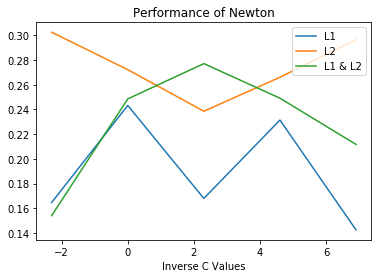

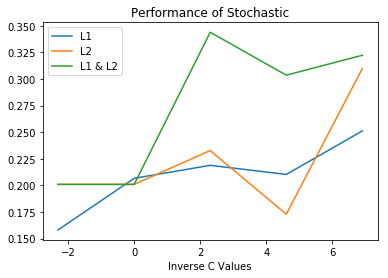

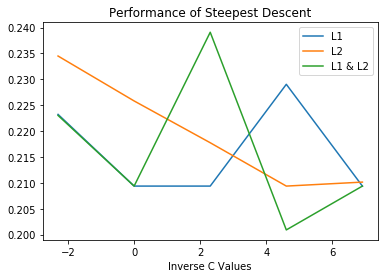

In [118]:
# Modified from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb

## Newton
df_perf = pd.DataFrame(NewtonMatrix)
df_perf.rename(columns={0: 'L1', 1: 'L2', 2: 'L1 & L2'}, inplace=True)
#print(df_performance)
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance of Newton")
plt.show()

## Stochastic

df_perf = pd.DataFrame(StochMatrix)
df_perf.rename(columns={0: 'L1', 1: 'L2', 2: 'L1 & L2'}, inplace=True)
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance of Stochastic")
plt.show()

# ## Steepest

df_perf = pd.DataFrame(SteepMatrix)
df_perf.rename(columns={0: 'L1', 1: 'L2', 2: 'L1 & L2'}, inplace=True)
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance of Steepest Descent")
plt.show()


As you can see above, I've chosen to optimize utilizing three parameters; the regularization cost, the regularization method, and the optimization method. The data used above comes from the original 80/20 test split. The visualizations show a signaficant amount of variance among the parameters. In addition, the accurancy is fairly low as well. There is almost no discernable pattern to the parameters and optimization. We can see that in general, Stochastic is the best optimization method and as C increases, so does the accuracy. 

Given this data, the best model is the Stochastic Descent method with L1 & L2 regularization and a C value of 0.1. These parameter values give the highest accuracy although it should be noted that it is only slightly better than some other parameters. 


### Scikit-Learn Comparison

In [160]:
# Modified from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb

# Best Method: Stoch (L1 & L2) C = 0.1
import time

# Let's start by finding the time to train the model and classify as well as getting an accuracy score

logistic = LogisticRegression()
skl_start = time.time()
logistic.fit(X_train,y_train)
skl_end = time.time()
skl_trainTime = skl_end - skl_start
print('Scikit-learn has taken ', skl_trainTime , ' seconds to train the model')

skl_start = time.time()
yhat_sk = logistic.predict(X_test)
skl_end = time.time()
skl_class = skl_end - skl_start

skl_acc = accuracy_score(y_test, yhat_sk)


print('Scikit-learn has taken ', skl_class , ' seconds to classify')
print('Scikit-learn has an accuracy of: ', skl_acc)


Scikit-learn has taken  81.09685897827148  seconds to train the model
Scikit-learn has taken  0.028074026107788086  seconds to classify
Scikit-learn has an accuracy of:  0.38118330992019606


In [177]:
# Now let's compare to our best classifier
# Best Method: Stoch (L1 & L2) C = 1

print('Our most accurate classifier is Stochastic Descent with L1 & L2 Regularization and Cost of 0.1. ')
lgr_stoch = MultiClassLogisticRegression(iterations=15000,C=0.1,solver='stochastic',reg='l1_and_l2')
mlr_start = time.time()
lgr_stoch.fit(X_train,y_train)
mlr_end = time.time()
mlr_train = mlr_end - mlr_start
print('Multi-class stochastic has taken ', mlr_train , ' seconds to train the model')

mlr_start = time.time()
yhat_st = lgr_stoch.predict(X_test)
mlr_end = time.time()
mlr_class = mlr_end - mlr_start

mlr_acc = accuracy_score(y_test, yhat_st)

print('Multi-class stochastic has taken ', mlr_class , ' seconds to classify')
print('Multi-class stochastic has an accuracy of: ', mlr_acc)

Our most accurate classifier is Stochastic Descent with L1 & L2 Regularization and Cost of 0.1. 
Multi-class stochastic has taken  1.192168951034546  seconds to train the model
Multi-class stochastic has taken  0.15340757369995117  seconds to classify
Multi-class stochastic has an accuracy of:  0.2520100427414293


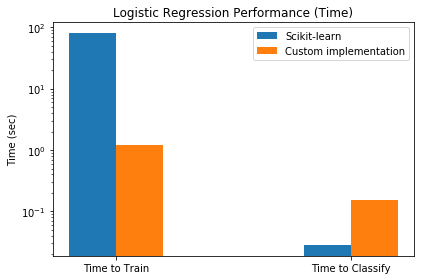

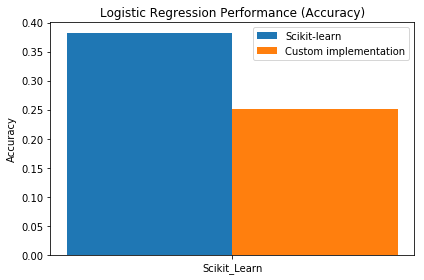

In [179]:
# Modified from https://github.com/tylergiallanza/CSE5324-Labs/blob/master/lab-three/Momin%20Notebook.ipynb

# Now lets visualize the data

time_skl = (skl_trainTime, skl_class)
time_mlr = (mlr_train, mlr_class)

fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.2

theirs = plt.bar(index, time_skl, bar_width, label="Scikit-learn")
ours = plt.bar(index + bar_width, time_mlr, bar_width, label="Custom implementation")


plt.ylabel('Time (sec)')
plt.title('Logistic Regression Performance (Time)')
plt.xticks(index + bar_width/2, ('Time to Train', 'Time to Classify'))
plt.legend()
 
plt.yscale('log')
plt.tight_layout()
plt.show()


# and the accuracy
#acc = (skl_acc, mlr_acc)

fig, ax = plt.subplots()
index = np.arange(1)
bar_width = 0.25

#acc_scores = plt.bar(index + bar_width, acc, bar_width, label="Custom implementation")
acc_scores_skl = plt.bar(index, skl_acc, bar_width, label="Scikit-learn")
acc_scores_mlr = plt.bar(index + bar_width, mlr_acc, bar_width, label="Custom implementation")

plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance (Accuracy)')
plt.xticks(index + bar_width/2, ('Scikit_Learn', 'Custom Implementation'))
plt.legend()

plt.tight_layout()
plt.show()

Not surprising, Scikit_Learn has a more accurate score than my custom multi-classifier. However, it is interesting to note that it took Scikit_Learn about 100 times longers to train the classifer than my custom implementation. 


## Deployment

Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

Considering the low accuracy scores for all optimization models, I would not recommand either implementation for a deployed machine learning model. I will say that if I had to chose, I would pick Sciki-Learn as the accuracy is constently better than my custom implementation. Even though the training takes longer, the time to classify is much less than my implementation. It should be noted that there are more than a million entrees for this dataset, even after the 80/20 split. Knmowing that, as well as the fact you really only need to train once (but possibly classify many times), Scikit-Learn is an even more obvious choice. 
